Make BGP-LLaMa and Mobile LLaMa web services.

With the web service, develop the real user cases for the network
operation and administrators.
For example, I think the real-time monitoring function and the
generation report in the natural language.
- IP prefix comparison from different regional bgp sources
- Specific AS report: AS18298 (CNU) BGP report for last 5 minutes
- Hourly/daily BGP monitoring summarization/report with plots
  * We can directly use 5-minute near real-time data of  bgp routing
tables and update messages.
- BGP anomaly detection reports

In [ ]:
import pybgpstream
stream = pybgpstream.BGPStream(
    # accessing ris-live
    project="ris-live",
    # filter to show only stream from rrc00
    filter="collector rrc00",
)

for elem in stream:
    print(elem)

In [1]:
import pybgpstream
stream = pybgpstream.BGPStream(
    project="routeviews-stream",
    record_type="updates"
)

for elem in stream:
    print(elem)

Collection period ended. Processing data...


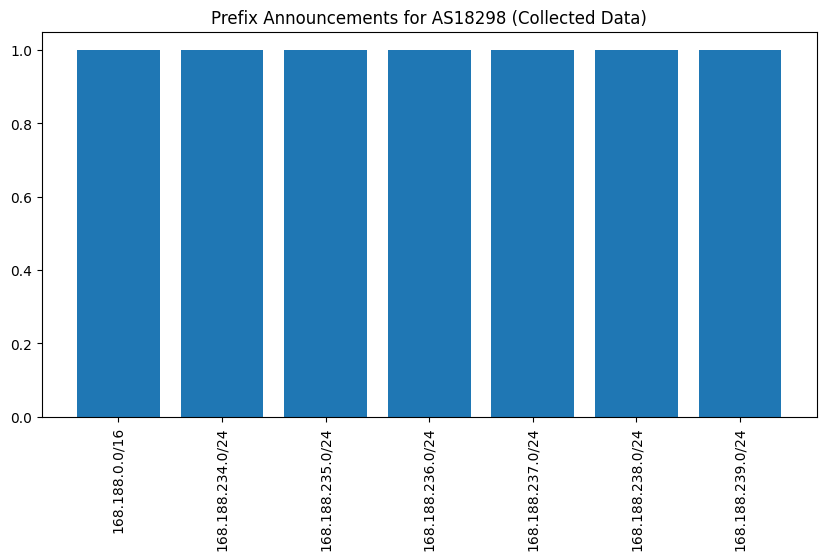

No data to display for Withdrawals for AS18298 (Collected Data)


In [39]:
import pybgpstream
import pandas as pd
import matplotlib.pyplot as plt
import time

# Define the collection period in seconds and the target AS
collection_period = 72000
target_as = "18298"

# Initialize pandas DataFrames for prefix announcements and withdrawals
prefix_announcements_df = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])
withdrawals_df = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])

# Create a BGPStream instance
stream = pybgpstream.BGPStream(
    project="ris-live",
    record_type="updates",
)

# Record the start time
start_time = time.time()

# Start the live stream
for rec in stream.records():
    # Check if the collection period has elapsed
    if collection_period < time.time() - start_time:
        print("Collection period ended. Processing data...")
        break

    current_time = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(rec.time))
    for elem in rec:
        as_path = elem.fields.get('as-path', '').split()
        prefix = elem.fields['prefix']

        # Check if the target AS is in the AS path
        if target_as in as_path:
            if elem.type == 'A':
                if prefix in prefix_announcements_df['Prefix'].values:
                    prefix_announcements_df.loc[prefix_announcements_df['Prefix'] == prefix, 'Count'] += 1
                else:
                    new_row = pd.DataFrame({'Time': [current_time], 'Prefix': [elem.fields['prefix']], 'Count': [1]})
                    prefix_announcements_df = pd.concat([prefix_announcements_df, new_row], ignore_index=True)
            elif elem.type == 'W':
                if prefix in withdrawals_df['Prefix'].values:
                    withdrawals_df.loc[withdrawals_df['Prefix'] == prefix, 'Count'] += 1
                else:
                    new_row = pd.DataFrame({'Time': [current_time], 'Prefix': [elem.fields['prefix']], 'Count': [1]})
                    withdrawals_df = pd.concat([withdrawals_df, new_row], ignore_index=True)

# Aggregate data
prefix_announcements_df = prefix_announcements_df.groupby(['Prefix']).size().reset_index(name='Counts')
withdrawals_df = withdrawals_df.groupby(['Prefix']).size().reset_index(name='Counts')

# Function to plot data from DataFrame
def plot_data(df, title):
    if not df.empty:
        plt.figure(figsize=(10, 5))
        plt.bar(df['Prefix'], df['Counts'], align='center')
        plt.xticks(rotation=90)
        plt.title(title)
        plt.show()
    else:
        print(f"No data to display for {title}")

# Plot the collected data
plot_data(prefix_announcements_df, f"Prefix Announcements for AS{target_as} (Collected Data)")
plot_data(withdrawals_df, f"Withdrawals for AS{target_as} (Collected Data)")

Collection period ended. Processing data...


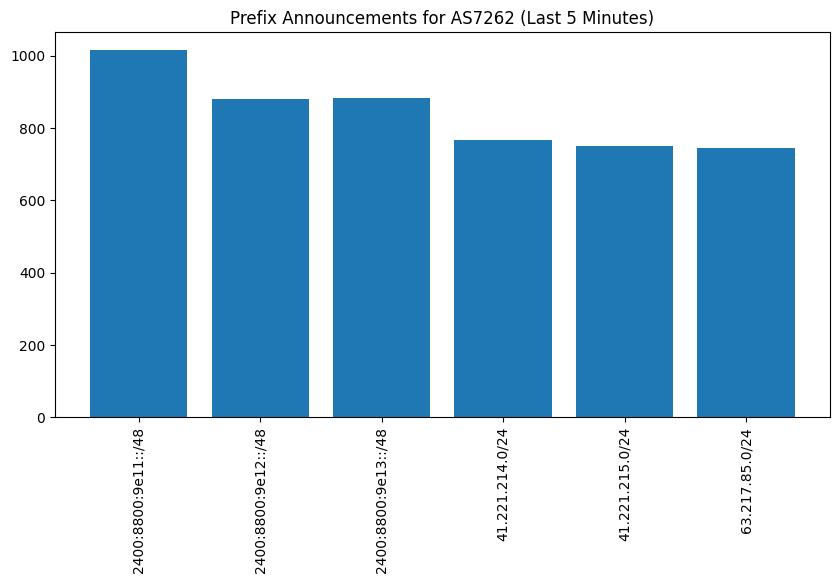

No data to display for Withdrawals for AS7262 (Last 5 Minutes)
remaining_time: 120


Collection period ended. Processing data...


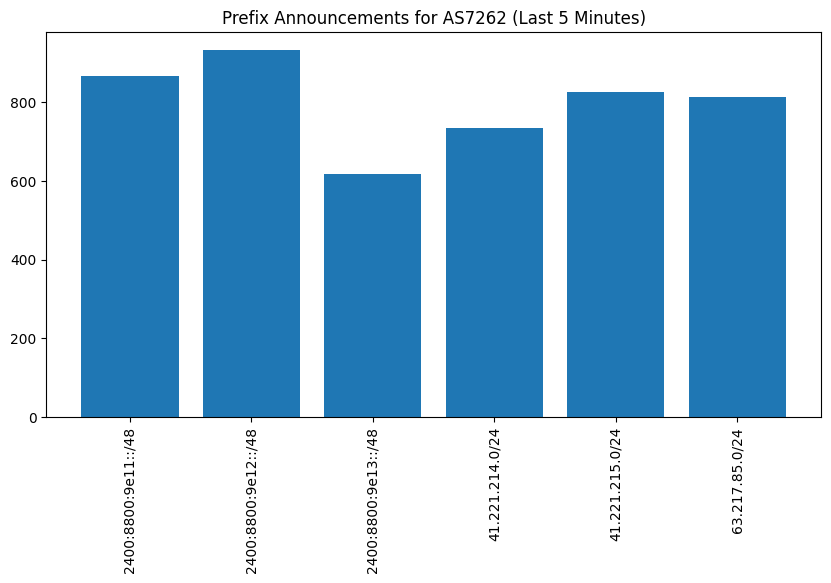

No data to display for Withdrawals for AS7262 (Last 5 Minutes)
remaining_time: 60
Collection period ended. Processing data...


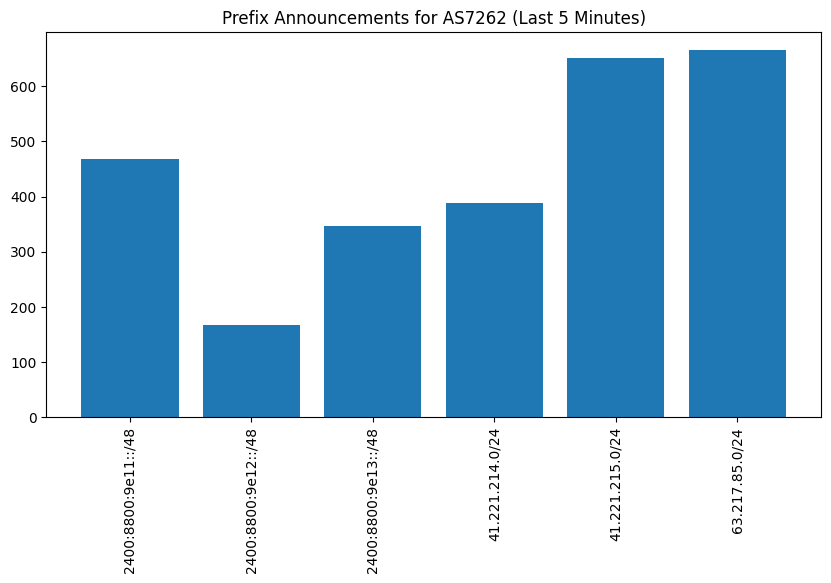

No data to display for Withdrawals for AS7262 (Last 5 Minutes)
remaining_time: 0


In [ ]:
import pybgpstream
import pandas as pd
import matplotlib.pyplot as plt
import threading
import time

target_as = "7262"

prefix_announcements_df = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])
withdrawals_df = pd.DataFrame(columns=['Time', 'Prefix', 'Count'])

def process_bgp_data(remaining_time):
    global prefix_announcements_df
    global withdrawals_df
    
    # Create a BGPStream instance
    stream = pybgpstream.BGPStream(
        project="ris-live",
        record_type="updates",
    )
    
    start_time = time.time()
    
    for rec in stream.records():
        current_time = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(rec.time))
        if 60 < time.time() - start_time:
            print("Collection period ended. Processing data...")
            break
        for elem in rec:
            as_path = elem.fields.get('as-path', '').split()
            prefix = elem.fields['prefix']
            if target_as in as_path:
                if elem.type == 'A':
                    if prefix in prefix_announcements_df['Prefix'].values:
                        prefix_announcements_df.loc[prefix_announcements_df['Prefix'] == prefix, 'Count'] += 1
                    else:
                        new_row = pd.DataFrame({'Time': [current_time], 'Prefix': [elem.fields['prefix']], 'Count': [1]})
                        prefix_announcements_df = pd.concat([prefix_announcements_df, new_row], ignore_index=True)
                elif elem.type == 'W':
                    if prefix in withdrawals_df['Prefix'].values:
                        withdrawals_df.loc[withdrawals_df['Prefix'] == prefix, 'Count'] += 1
                    else:
                        new_row = pd.DataFrame({'Time': [current_time], 'Prefix': [elem.fields['prefix']], 'Count': [1]})
                        withdrawals_df = pd.concat([withdrawals_df, new_row], ignore_index=True)

    # Plot data
    plot_data(prefix_announcements_df, f"Prefix Announcements for AS{target_as} (Last 5 Minutes)")
    plot_data(withdrawals_df, f"Withdrawals for AS{target_as} (Last 5 Minutes)")

    # Empty the DataFrames after plotting
    prefix_announcements_df = prefix_announcements_df[0:0]
    withdrawals_df = withdrawals_df[0:0]

    # Schedule next execution
    remaining_time -= 60
    print(f"remaining_time: {remaining_time}")
    if remaining_time > 0:
        threading.Timer(0, process_bgp_data, args=(remaining_time,)).start()

def plot_data(df, title):
    if not df.empty:
        grouped_df = df.groupby('Prefix').sum().reset_index()
        plt.figure(figsize=(10, 5))
        plt.bar(grouped_df['Prefix'], grouped_df['Count'], align='center')
        plt.xticks(rotation=90)
        plt.title(title)
        plt.show()
    else:
        print(f"No data to display for {title}")

total_collection_period = 60 * 3
process_bgp_data(total_collection_period)


In [ ]:
import pybgpstream
import pandas as pd
import matplotlib.pyplot as plt
import threading
import time

target_prefix = "41.221.215.0/24"

# Initialize pandas DataFrames for announcements and withdrawals related to the target prefix
prefix_announcements_df = pd.DataFrame(columns=['Time', 'AS Path', 'Count'])
withdrawals_df = pd.DataFrame(columns=['Time', 'AS Path', 'Count'])

# Function to process BGP data
def process_bgp_data(remaining_time):
    global prefix_announcements_df
    global withdrawals_df
    
    # Create a BGPStream instance
    stream = pybgpstream.BGPStream(
        project="ris-live",
        record_type="updates",
    )

    # Start the live stream and collect data for 5 minutes
    start_time = time.time()
    
    for rec in stream.records():
        current_time = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(rec.time))
        if 300 < time.time() - start_time:
            print("Collection period ended. Processing data...")
            break
        for elem in rec:
            as_path = elem.fields.get('as-path', '')
            prefix = elem.fields['prefix']
            if prefix == target_prefix:
                if elem.type == 'A':
                    if as_path in prefix_announcements_df['AS Path'].values:
                        prefix_announcements_df.loc[prefix_announcements_df['AS Path'] == as_path, 'Count'] += 1
                    else:
                        new_row = pd.DataFrame({'Time': [current_time], 'AS Path': [as_path], 'Count': [1]})
                        prefix_announcements_df = pd.concat([prefix_announcements_df, new_row], ignore_index=True)

    # Plot data
    plot_data(prefix_announcements_df, f"Top 10 Announcements for Prefix {target_prefix} (Last 5 Minutes)")

    # Empty the DataFrames after plotting
    prefix_announcements_df = prefix_announcements_df[0:0]

    # Schedule next execution
    remaining_time -= 300
    print(f"remaining_time: {remaining_time}")
    if remaining_time > 0:
        threading.Timer(0, process_bgp_data, args=(remaining_time,)).start()

def plot_data(df, title):
    if not df.empty:
        grouped_df = df.groupby('AS Path').sum().reset_index().sort_values(by='Count', ascending=False).head(10)
        plt.figure(figsize=(10, 5))
        plt.bar(grouped_df['AS Path'], grouped_df['Count'], align='center')
        plt.xticks(rotation=90)
        plt.title(title)
        plt.show()
    else:
        print(f"No data to display for {title}")

# Specify total collection period (e.g., 15 minutes)
total_collection_period = 60 * 15
process_bgp_data(total_collection_period)

## Occurances 

Collection period ended. Processing data...


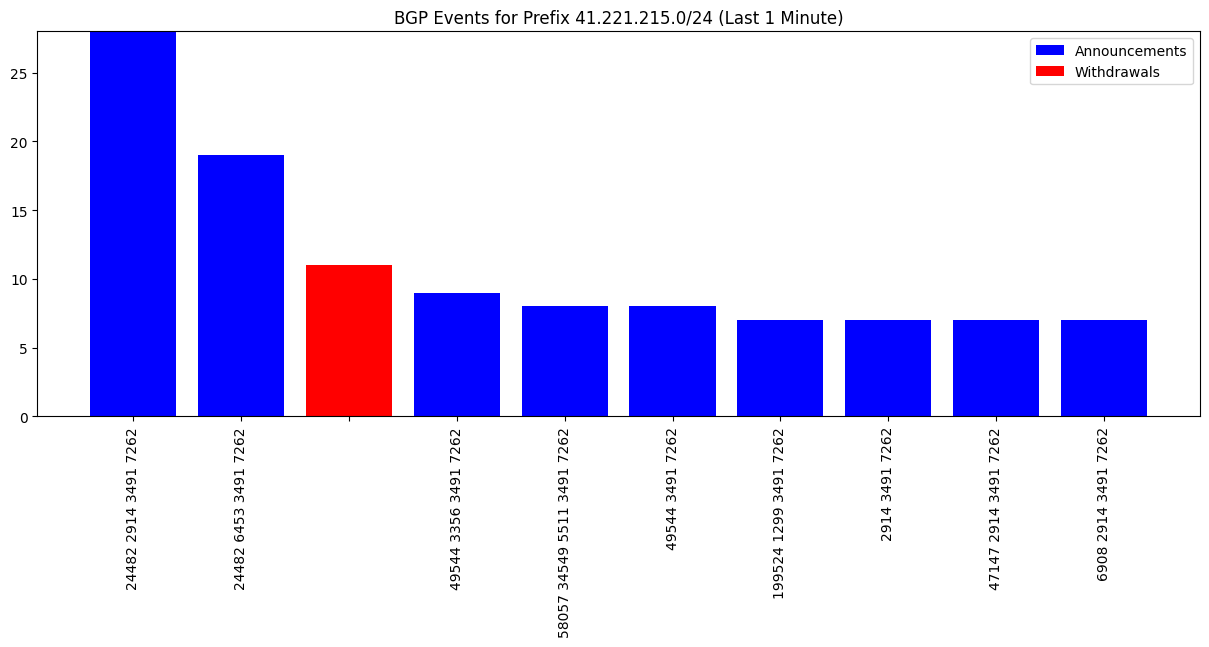

remaining_time: 120


Collection period ended. Processing data...


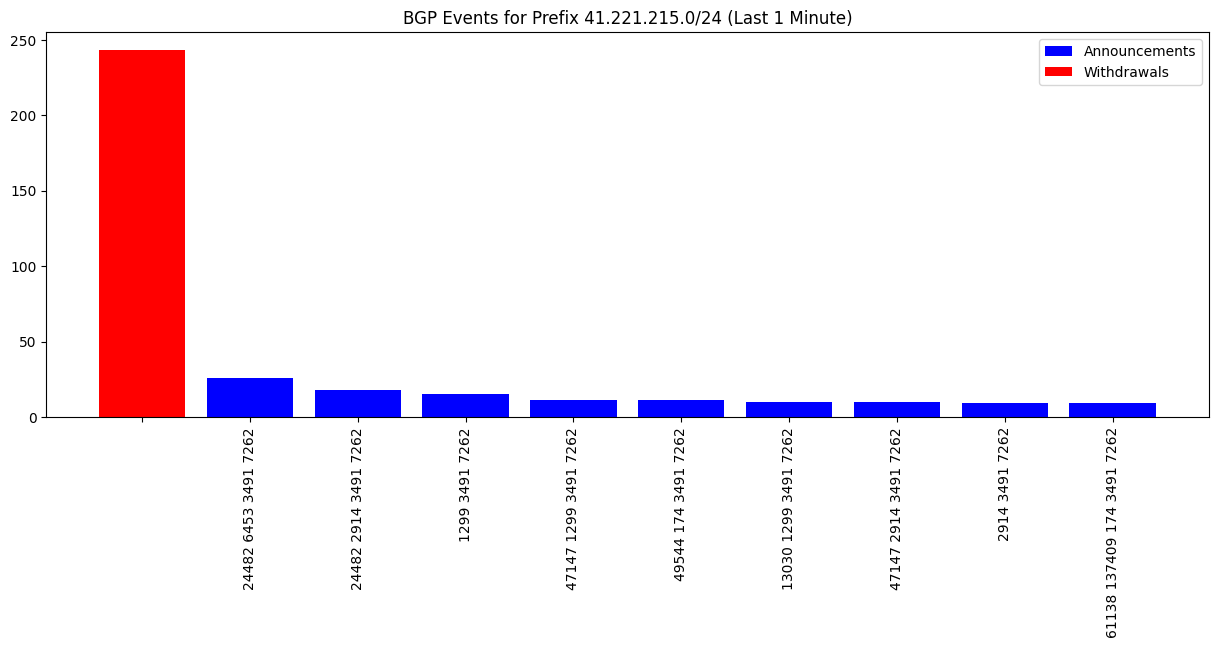

remaining_time: 60
Collection period ended. Processing data...


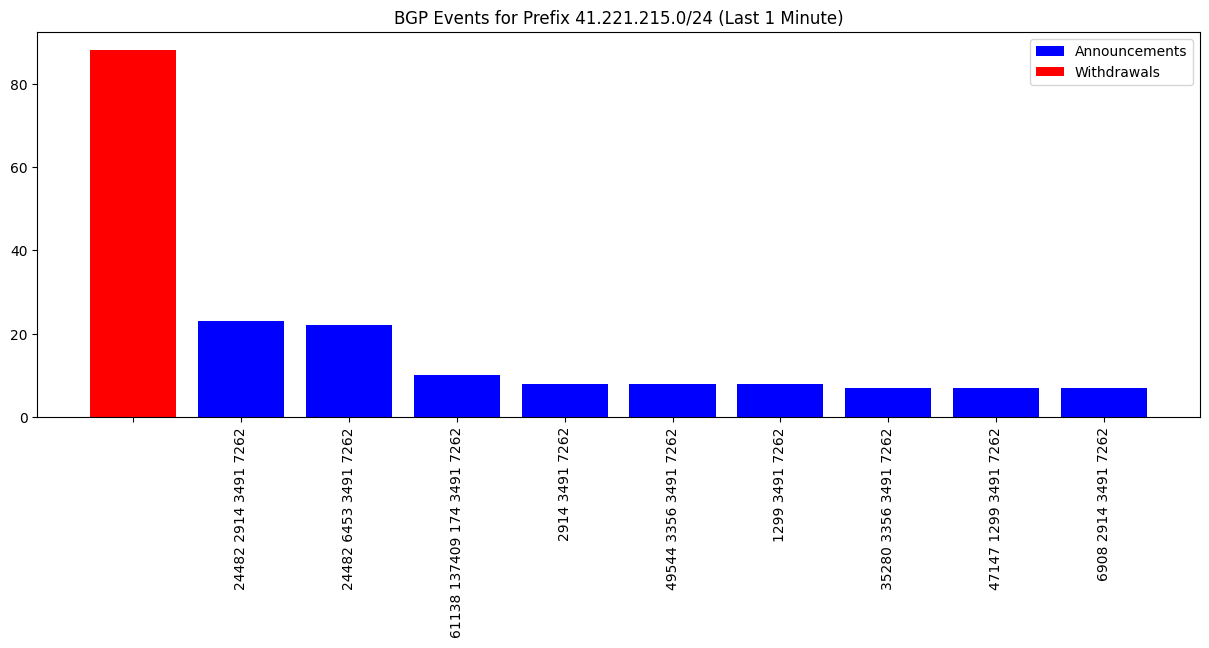

remaining_time: 0


In [93]:
import pybgpstream
import pandas as pd
import matplotlib.pyplot as plt
import threading
import time

target_prefix = "41.221.215.0/24"

# Initialize a pandas DataFrame to track both announcements and withdrawals
bgp_events_df = pd.DataFrame(columns=['Time', 'AS Path', 'Announcements', 'Withdrawals'])

# Function to process BGP data
def process_bgp_data(remaining_time):
    global bgp_events_df
    # Create a BGPStream instance
    stream = pybgpstream.BGPStream(
        project="ris-live",
        record_type="updates",
    )

    # Start the live stream and collect data for 1 minute
    start_time = time.time()

    for rec in stream.records():
        current_time = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(rec.time))
        if 60 < time.time() - start_time:
            print("Collection period ended. Processing data...")
            break
        for elem in rec:
            as_path = elem.fields.get('as-path', '')
            prefix = elem.fields['prefix']
            if prefix == target_prefix:
                bgp_events_df = update_bgp_events(bgp_events_df, current_time, as_path, elem.type)

    # Plot data
    plot_data(bgp_events_df, f"BGP Events for Prefix {target_prefix} (Last 1 Minute)")

    # Empty the DataFrame after plotting
    # bgp_events_df = bgp_events_df[0:0]

    # Schedule next execution
    remaining_time -= 60
    print(f"remaining_time: {remaining_time}")
    if remaining_time > 0:
        threading.Timer(0, process_bgp_data, args=(remaining_time,)).start()

def update_bgp_events(df, current_time, as_path, event_type):
    if df[df['AS Path'] == as_path].empty:
        # Add new row if AS path doesn't exist
        new_row = {'Time': current_time, 'AS Path': as_path, 'Announcements': 0, 'Withdrawals': 0}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    # Update counts based on event type
    if event_type == 'A':
        df.loc[df['AS Path'] == as_path, 'Announcements'] += 1
    elif event_type == 'W':
        df.loc[df['AS Path'] == as_path, 'Withdrawals'] += 1

    return df

def plot_data(df, title):
    if not df.empty:
        # Aggregate counts and sort by total events
        df_grouped = df.groupby('AS Path').agg({'Announcements': 'sum', 'Withdrawals': 'sum'})
        df_grouped['Total'] = df_grouped['Announcements'] + df_grouped['Withdrawals']
        df_grouped = df_grouped.sort_values(by='Total', ascending=False).head(10).reset_index()

        # Plotting
        plt.figure(figsize=(15, 5))

        # Plot announcements
        plt.bar(df_grouped['AS Path'], df_grouped['Announcements'], align='center', color='blue', label='Announcements')

        # Plot withdrawals
        plt.bar(df_grouped['AS Path'], df_grouped['Withdrawals'], align='center', color='red', bottom=df_grouped['Announcements'], label='Withdrawals')

        plt.xticks(rotation=90)
        plt.title(title)
        plt.legend()
        plt.show()
    else:
        print(f"No data to display for {title}")

# Specify total collection period (e.g., 3 minutes)
total_collection_period = 60 * 3
process_bgp_data(total_collection_period)

In [2]:
import pybgpstream
import pandas as pd
import threading
import time

target_prefix = "41.221.215.0/24"

# Initialize a pandas DataFrame to track announcements
bgp_announcements_df = pd.DataFrame(columns=['Time', 'AS Path', 'Count'])
total_withdrawals = 0  # Counter for total withdrawals

# Function to process BGP data
def process_bgp_data(remaining_time):
    global bgp_announcements_df, total_withdrawals

    # Create a BGPStream instance
    stream = pybgpstream.BGPStream(
        project="ris-live",
        record_type="updates",
    )

    # Start the live stream and collect data for 1 minute
    start_time = time.time()

    for rec in stream.records():
        current_time = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(rec.time))
        if 60 < time.time() - start_time:
            print("Collection period ended.")
            break
        for elem in rec:
            prefix = elem.fields['prefix']
            if prefix == target_prefix:
                if elem.type == 'A':
                    as_path = elem.fields.get('as-path', '')
                    bgp_announcements_df = update_announcements(bgp_announcements_df, current_time, as_path)
                elif elem.type == 'W':
                    total_withdrawals += 1

    # Schedule next execution
    remaining_time -= 60
    if remaining_time > 0:
        threading.Timer(0, process_bgp_data, args=(remaining_time,)).start()
    else:
        print_summary(bgp_announcements_df, total_withdrawals)

def update_announcements(df, current_time, as_path):
    if df[df['AS Path'] == as_path].empty:
        new_row = {'Time': current_time, 'AS Path': as_path, 'Count': 1}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    else:
        df.loc[df['AS Path'] == as_path, 'Count'] += 1

    return df

def print_summary(df, withdrawals):
    if not df.empty:
        total_announcements = df['Count'].sum()
        print(f"Total Announcements: {total_announcements}")
        print(f"Total Withdrawals: {withdrawals}")

        # Top 10 AS Paths by Announcements
        top_as_paths = df.groupby('AS Path')['Count'].sum().sort_values(ascending=False).head(10)
        print("Top 10 AS Paths by Announcements:")
        print(top_as_paths)
    else:
        print("No announcements data to display.")
        print(f"Total Withdrawals: {withdrawals}")

# Specify total collection period (e.g., 3 minutes)
total_collection_period = 60 * 3
process_bgp_data(total_collection_period)

Collection period ended.


Collection period ended.
Collection period ended.
Total Announcements: 1720
Total Withdrawals: 466
Top 10 AS Paths by Announcements:
AS Path
24482 6453 3491 7262           64
61138 137409 6461 3491 7262    37
24482 2914 3491 7262           35
47147 2914 3491 7262           24
13030 1299 3491 7262           24
6461 3491 7262                 21
49544 3356 3491 7262           20
2914 3491 7262                 18
8218 6461 3491 7262            17
35280 6453 3491 7262           16
Name: Count, dtype: object


# IP prefix comparison from different regional bgp sources

In [2]:
import pybgpstream
from datetime import datetime
from collections import defaultdict

# Define the prefixes and collectors
prefixes_to_compare = ["41.221.214.0/24", "63.217.85.0/24"]
collectors = ["route-views.linx", "route-views.sydney", "route-views.sao"]

# Define the time window for data collection
start_time = "2023-01-01 00:00:00 UTC"
end_time = "2023-01-02 00:00:00 UTC"

# Collect data
prefix_data = defaultdict(lambda: defaultdict(list))
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    collectors=collectors,
    record_type="updates"
)

for rec in stream.records():
    if rec.status == "valid":
        collector = rec.collector
        for elem in rec:
            # Filter based on prefix within the loop
            if elem.type == "A" and elem.fields["prefix"] in prefixes_to_compare:
                as_path = elem.fields["as-path"]
                prefix_data[elem.fields["prefix"]][collector].append(as_path)

# Compare data
for prefix, data in prefix_data.items():
    print(f"Comparing for prefix {prefix}:")
    for collector, paths in data.items():
        print(f"  Collector {collector} announced paths: {paths}")
    print("-" * 40)


# Enable caching of downloaded MRT files

In [ ]:
import pybgpstream
stream = pybgpstream.BGPStream()

stream.set_data_interface_option("broker", "cache-dir", "/path/to/cache")

# Report of messages from multiple collectors

In [ ]:
import pybgpstream
from collections import defaultdict

# Initialize BGPStream
stream = pybgpstream.BGPStream(
    project="ris-live",
    record_type="updates",
)

# Initialize a dictionary to store data by collector
collector_data = defaultdict(int)

# Process BGP records
for rec in stream.records():
    # Get collector name
    collector = rec.collector
    # Process each BGP element in the record
    for elem in rec:
        # You can further process elem here based on your requirements

        # Increment count for this collector
        collector_data[collector] += 1

# Summarize and print data for each collector
for collector, count in collector_data.items():
    print(f"Collector {collector} has {count} updates.")

# Depending on your requirement, you can further process this data
# to provide more detailed summaries (e.g., count of specific types of updates).
